# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


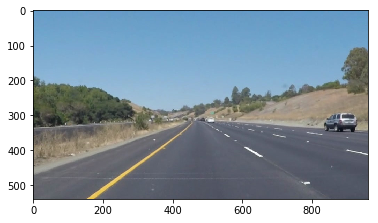

In [2]:
#reading in an image
# image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def find_left_and_right_lines( img, lines , vertices):
    
    # get the minimum ( the upmost ) point for a line in lines
    # this is till where I will extrapolate
    # y_min = round( min( min(y1,y2) for x1,y1,x2,y2 in [line[0] for line in lines] ) )
    ## but let's say we always want to extrapolate till 
    imgshape = img.shape
    y_min = round( vertices[0][1][1] )  # this is the distance of the region of interest from the top of the image
      
    right_lane_start = []
    right_lane_end = []
    right_lane_weight = []
    
    left_lane_start = []
    left_lane_end = []
    left_lane_weight = []

    # we want slopes ~ between 25 and 60 degrees for the lanes ( given our camera position), so
    low_slope = math.tan( 25 * math.pi / 180 ) # from degrees to radians, then tangent
    high_slope = math.tan( 60 * math.pi / 180 )
    
    if len(lines)>0:
        for line in lines:
            for x1,y1,x2,y2 in line:

                if x2!=x1:
                    # Get the slope of the line/segment
                    s  = (y2-y1)/(x2-x1)
                    # get the bias from the segment
                    b = y1 - s*x1
                    # get its extrapolated start and end X points
                    # X start implies x=(y_0-b)/slope with y_0=imgshape[0]
                    x_s = (imgshape[0]-b)/s
                    # X end implies x=(y_min-b)/slope
                    x_e = (y_min-b)/s

                    # Find the length of this segment
                    l = math.sqrt( (x1-x2)**2 + (y1-y2)**2 )
                    # segments are going to be weighted proportionally to their length

                    # we also want to enforce the extended lines to fot in the region of interest, as
                    # anything outside is likely to be an outlier
                    if x_e > vertices[0][1][0] and x_e < vertices[0][2][0] and x_s > imgshape[1]*0.05 and x_s < imgshape[1]:
                        ## Now, we expect 2 lines one with positive slope and one with negative slope
                        if s > low_slope and s < high_slope:
                            right_lane_start.append( x_s )
                            right_lane_end.append( x_e )
                            right_lane_weight.append( l )
                        elif s < -low_slope and s > -high_slope :
                            left_lane_start.append( x_s )
                            left_lane_end.append( x_e )
                            left_lane_weight.append( l )

    
    res = []
    
    # write right lane and left lane  start and end points
    if len(right_lane_weight) > 0:
        # Normalise the weights
        nc = sum(right_lane_weight)
        right_lane_weight = [w/nc for w in right_lane_weight]

        rls = int(round( sum( s*w for s,w in zip(right_lane_start,right_lane_weight) )))
        rle = int(round( sum( e*w for e,w in zip(right_lane_end,right_lane_weight) )))
        res.append( (rls , imgshape[0] , rle , y_min) )
    
    if len(left_lane_weight) > 0:
        # Normalise the weights
        nc = sum(left_lane_weight)
        left_lane_weight = [w/nc for w in left_lane_weight]
    
        lls = int(round( sum( s*w for s,w in zip(left_lane_start,left_lane_weight) )))
        lle = int(round( sum( e*w for e,w in zip(left_lane_end,left_lane_weight) )))
        res.append( (lls , imgshape[0] , lle , y_min) )

    return res



def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if len(lines)>0:
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns the list of lines detected
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1., β=0.8, γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



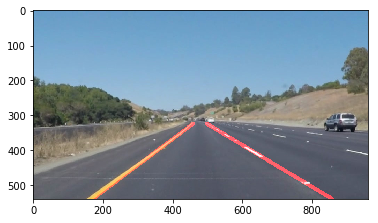

In [6]:
# Build the pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def process_image ( image ):


    ## Transform the image to grayscale
    gray = grayscale(image)

    # plt.imshow(gray, cmap='gray')

    # Apply Gaussian smoothing
    kernel_size = 5
    gray_blur = gaussian_blur(gray,kernel_size)

    # Detect edges using Canny
    low_threshold = 20 / 0.75**5
    high_threshold = 50 / 0.75**5

    canny_img = canny(gray_blur,low_threshold,high_threshold)

    # Delimitate the image in a certain region of interest
    imshape = image.shape
    vertices = np.array([[(0.1*imshape[1],0.92*imshape[0]),
                          (imshape[1]*0.45, imshape[0]*0.6),
                          (imshape[1]*0.55, imshape[0]*0.6),
                          (imshape[1]*0.96,0.92*imshape[0])]],
                dtype=np.int32)
    canny_masked = region_of_interest(canny_img,vertices)

    # Run Hough on the canny image to find lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments

    lines = hough_lines(canny_masked, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Filter the lines to find the two lanes
    filtered_lines = find_left_and_right_lines(canny_masked,lines,vertices)

    # if the result is less than 2 lanes, repeat with more permissive parameters
    while len(filtered_lines) < 2 and low_threshold >= 20:
        low_threshold = low_threshold * 0.75
        high_threshold = high_threshold * 0.75
        
        canny_img = canny(gray_blur,low_threshold,high_threshold)
        canny_masked = region_of_interest(canny_img,vertices)
        lines = hough_lines(canny_masked, rho, theta, threshold, min_line_length, max_line_gap)
        filtered_lines = find_left_and_right_lines(canny_masked,lines,vertices)
        
        if len(filtered_lines) < 2:
            lines = hough_lines(canny_masked, rho, theta, threshold, min_line_length, max_line_gap*1.5)
            filtered_lines = find_left_and_right_lines(canny_masked,lines,vertices)
    
    # Write the hough lines to a blank image    
    line_img = np.zeros((imshape[0], imshape[1], 3), dtype=np.uint8)
    draw_lines(line_img, filtered_lines)

    # Draw that final averaged image
    new_image = weighted_img(line_img,image)
    
    # vertices = vertices.reshape((-1,1,2))
    # cv2.polylines(new_image,[vertices],True,(0,0,255),thickness=6)
    
    return new_image


new_image = process_image(image)

## Plot the final image
plt.imshow(new_image)

## Test on Videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 58.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.9 s, sys: 597 ms, total: 7.49 s
Wall time: 4.15 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:11<00:00, 57.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.9 s, sys: 1.52 s, total: 21.5 s
Wall time: 12.2 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Challenge


In [12]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:08<00:00, 29.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.5 s, sys: 1.17 s, total: 13.7 s
Wall time: 9.22 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))